In [1]:
from astropy.table import Table
from astroquery.gaia import Gaia
import numpy as np
import matplotlib.pyplot as plt
from pyesasky import ESASkyWidget
from pyesasky import Catalogue
from pyesasky import CatalogueDescriptor
from pyesasky import MetadataDescriptor
from pyesasky import MetadataType

In [2]:
def make_canvas(title = '', 
                xlabel = '', 
                ylabel = '', 
                show_grid = False, 
                show_legend = False, 
                fontsize = 12):
    ""
    "Generic function to simplify the editing of plots"
    ""
    plt.title(title,    fontsize = fontsize)
    plt.xlabel(xlabel,  fontsize = fontsize)
    plt.ylabel(ylabel , fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    if show_grid:
        plt.grid()
    if show_legend:
        plt.legend(fontsize = fontsize)


def esasky_oplot(inp_cat, 
                 catalogueName = 'my_cat', 
                 color = 'red', 
                 lineWidth = 2):
    ""
    "ESASky catalogue plotter"
    ""
    catalogue = Catalogue(catalogueName = catalogueName, cooframe = 'J2000', color = color, lineWidth = lineWidth)
    for i in range(len(inp_cat)):
        catalogue.addSource(inp_cat['source_id'][i], inp_cat['ra'][i], inp_cat['dec'][i], i + 1, [], [])
    esasky.overlayCatalogueWithDetails(catalogue)


def plot_sampled_spec(inp_table, 
                      color = 'blue', 
                      title = '', 
                      fontsize = 16, 
                      show_legend = True, 
                      show_grid = True, 
                      linewidth = 2, 
                      legend = '', 
                      figsize = [25,7], 
                      show_plot = True):
    ""
    "RVS & XP sampled spectrum plotter. 'inp_table' MUST be an Astropy-table object."
    ""
    if show_plot:
        fig      = plt.figure(figsize=figsize)
    xlabel   = f'Wavelength [{inp_table["wavelength"].unit}]'
    ylabel   = f'Flux [{inp_table["flux"].unit}]'
    plt.plot(inp_table['wavelength'], inp_table['flux'], '-', linewidth = linewidth, label = legend)
    make_canvas(title = title, xlabel = xlabel, ylabel = ylabel, fontsize= fontsize, show_legend=show_legend, show_grid = show_grid)
    if show_plot:
        plt.show()

## Download data sample

The query below retrieves a 1-degree cone-search centred in Alcyone (brightest star of the Pleiades open cluster)

In [3]:
radius  = 1.0        # Degrees
inp_ra  = 56.87125   # Degrees
inp_dec = 24.10493   # Degrees

In [4]:
query = f"SELECT * FROM gaiadr3.gaia_source_lite \
WHERE 1 = CONTAINS(POINT({inp_ra}, {inp_dec}), CIRCLE(ra, dec, {radius})) AND \
ruwe <1.4 AND parallax_over_error > 10"

In [5]:
job     = Gaia.launch_job_async(query)
results = job.get_results()
print(f'Table size (rows): {len(results)}')
results['source_id', 'ra', 'dec', 'pmra' ,'pmdec', 'parallax']

INFO: Query finished. [astroquery.utils.tap.core]
Table size (rows): 4032


source_id,ra,dec,pmra,pmdec,parallax
,deg,deg,mas / yr,mas / yr,mas
int64,float64,float64,float64,float64,float64
69805798521250560,56.24863115999279,24.642582257680882,2.190487348950862,-13.465314592937117,0.9437596679009509
69805901600465152,56.24727995894163,24.65570538537785,0.49759409475044836,-3.8273885658895668,0.8311574217226121
69805901600465536,56.248963878828214,24.646361688721974,7.372404958972663,-6.369812663837182,1.5491388879533554
69805935960203392,56.27054240577331,24.6474754189256,6.8928967344856975,-8.05494305625505,1.025008949947923
69806039039416832,56.27740714247925,24.678409040272616,20.24411977407674,-44.80748682496666,7.5284014269211195
69806107758894976,56.24396966595952,24.665878429795082,30.429650578356245,-21.351212463789484,2.9152954059140637
69806107758895104,56.241044070606705,24.664036267040704,7.383219341257357,-1.4144879294953903,1.0237043621074358
69806142118633984,56.21224469443437,24.666776076898838,-2.299934195324371,-7.141252554177461,0.849064870039556


## Inspect Results

Pleiades candidate sources are selected by filtering a circular area (radius = 3 mas/yr) around the Pleiades proper motion distribution (centre at ~ [20,-50] mas/yr in [pmra, pmdec])

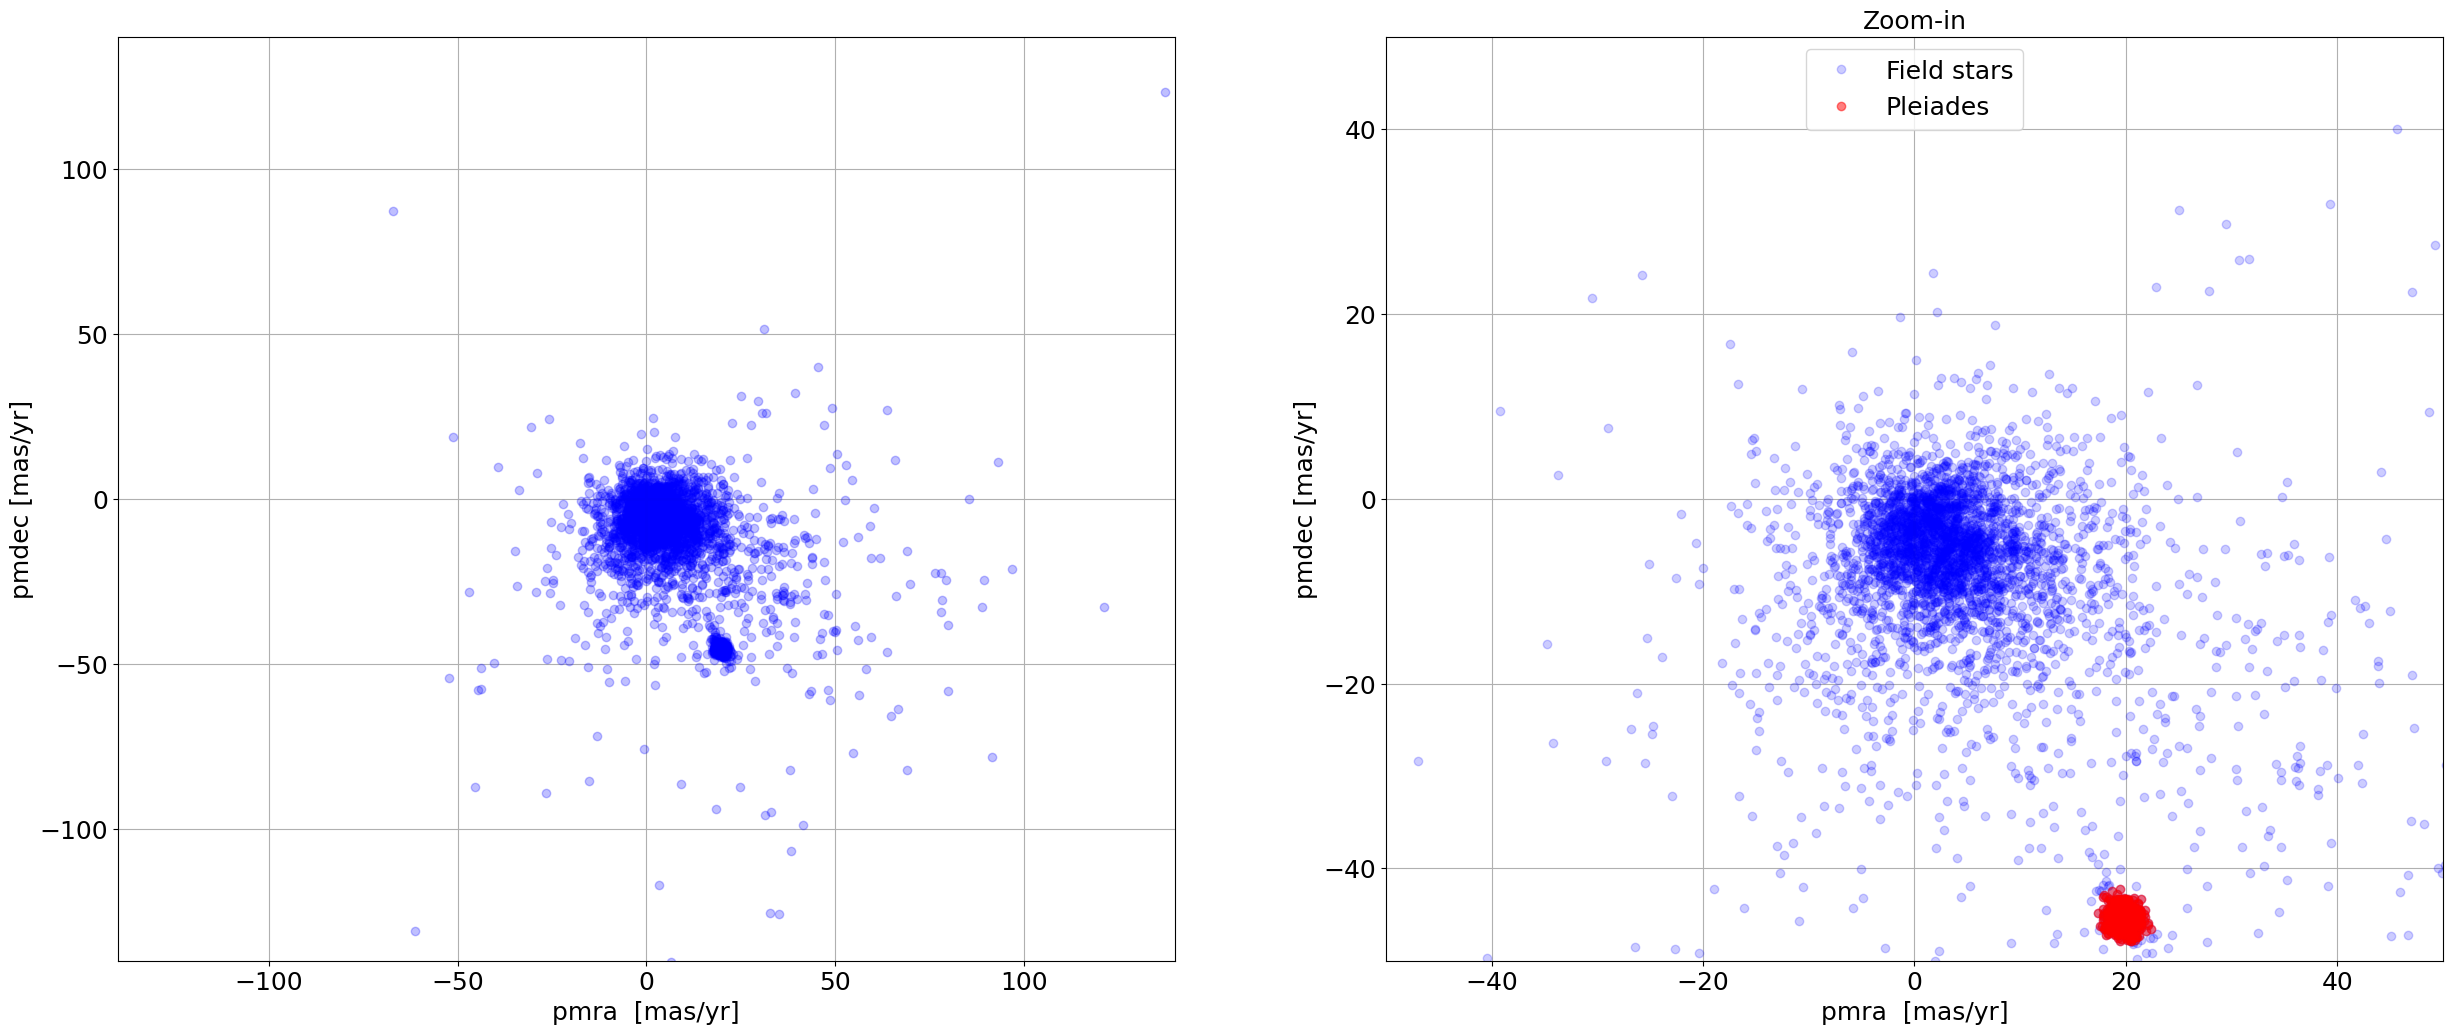

In [6]:
# Identify Pleiades candidate members =======
radius_pm = 3   # Radius applied to select Pleiades sample in the PMRA-PMDEC space
pmra_c    = 20  # Approx. centre of the Pleiades Cluster pmra.
pmdec_c   = -45 # Approx. centre of the Pleiades Cluster pmdec.
els       = np.sqrt((results['pmra']-pmra_c)**2 + (results['pmdec']-pmdec_c)**2) <radius_pm # Selected Pleiades sample
pl_samp   = results[els]



# Plot & Zoom ===============================
fig       = plt.figure(figsize=[30,12])
fontsize  = 18

# Panel 1 ===============
plt.subplot(121)
plt.plot(results['pmra'], results['pmdec'], 'bo', alpha = 0.25)
make_canvas(xlabel='pmra  [mas/yr]',ylabel='pmdec [mas/yr]', fontsize = fontsize, show_grid = True)
z_fac = 140   # Zoom-in factor
plt.xlim([-z_fac,z_fac])
plt.ylim([-z_fac,z_fac])


# Panel 2 ===============
plt.subplot(122)
plt.plot(results['pmra'], results['pmdec'], 'bo', alpha = 0.20, label = 'Field stars')
plt.plot(pl_samp['pmra'], pl_samp['pmdec'], 'ro', alpha = 0.50, label = 'Pleiades')
z_fac = 50   # Zoom-in factor
plt.xlim([-z_fac,z_fac])
plt.ylim([-z_fac,z_fac])


make_canvas(title = 'Zoom-in', 
            xlabel='pmra  [mas/yr]',
            ylabel='pmdec [mas/yr]', 
            fontsize = fontsize, 
            show_grid = True, 
            show_legend = True)
plt.show()

## Show results in esasky

In [7]:
esasky = ESASkyWidget()
esasky

ESASkyWidget(layout=Layout(align_self='stretch', height='400px'))

In [ ]:
# Plot Cone Search in ESASky =================
esasky_oplot(results, catalogueName = 'Pleiades Cone Search', color = 'blue')
esasky.setFoV(radius*1.5)
esasky.setGoToRADec(results['ra'].mean(), results['dec'].mean())
esasky_oplot(pl_samp, catalogueName = 'Pleiades selected', color = 'red')

### show different sub-samples in esasky

In [ ]:
esasky_oplot(pl_samp[pl_samp['has_xp_sampled'] == True],    catalogueName = 'Pleiades XP Sampled',    color = 'white')
esasky_oplot(pl_samp[pl_samp['has_xp_continuous'] == True], catalogueName = 'Pleiades XP Continuous', color = 'green')

# esasky_oplot(pl_samp[pl_samp['has_epoch_photometry'] == True], catalogueName = 'Pleiades Epoch Phot', color = 'white')
# esasky_oplot(pl_samp[pl_samp['has_rvs'] == True],              catalogueName = 'Pleiades RVS',        color = 'green')

## DOWNLOAD THE DATALINK PRODUCTS ASSOCIATED TO THE SELECTED (PLEIADES) SAMPLE

DataLink products are labelled as: "<retrieval_type>-<data release> <source_id>.<format>", where:

retrieval_type = 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
data_structure = 'INDIVIDUAL', 'COMBINED', 'RAW'
For more information about DataLink products please read the tutorials in this Section.
    

### XP sampled spectra

In [8]:
inp_samp       = pl_samp[pl_samp['has_xp_sampled'] == True]
retrieval_type = 'XP_SAMPLED'
data_structure = 'COMBINED'
dl_key         = 'XP_SAMPLED_COMBINED.xml'  # With Python f-strings: dl_key = f'{retrieval_type}_{data_structure}.xml'


datalink    = Gaia.load_data(ids=inp_samp['source_id'], retrieval_type=retrieval_type, data_structure = data_structure)

print(f"* {len(datalink['XP_SAMPLED_COMBINED.xml'])} XP sampled spectra have been downloaded")

* 120 XP sampled spectra have been downloaded


The ```datalink``` instance retrieved above consists of a 1-element Python dictionary that, in turn, contains various individual spectra. Each of these contain data (stored in a table) and metadata. The code below shows the content of the XP Spectra for one selected source, namely the one with ```index=100```. To change the source, simply modify the ```index=100``` variable in line #2.

Listing XP spectra for: Gaia DR3 66808220587759104


wavelength,flux,flux_error
nm,W / (m2 nm),W / (m2 nm)
float64,float32,float32
336.0,2.11973e-17,7.942415e-18
338.0,1.15127155e-17,5.8046068e-18
340.0,9.963061e-18,4.7220395e-18
342.0,1.3008566e-17,4.0508565e-18
344.0,1.6232869e-17,3.870236e-18
346.0,1.6739485e-17,3.829343e-18
348.0,1.4194591e-17,3.9990886e-18
350.0,1.12620136e-17,4.279232e-18


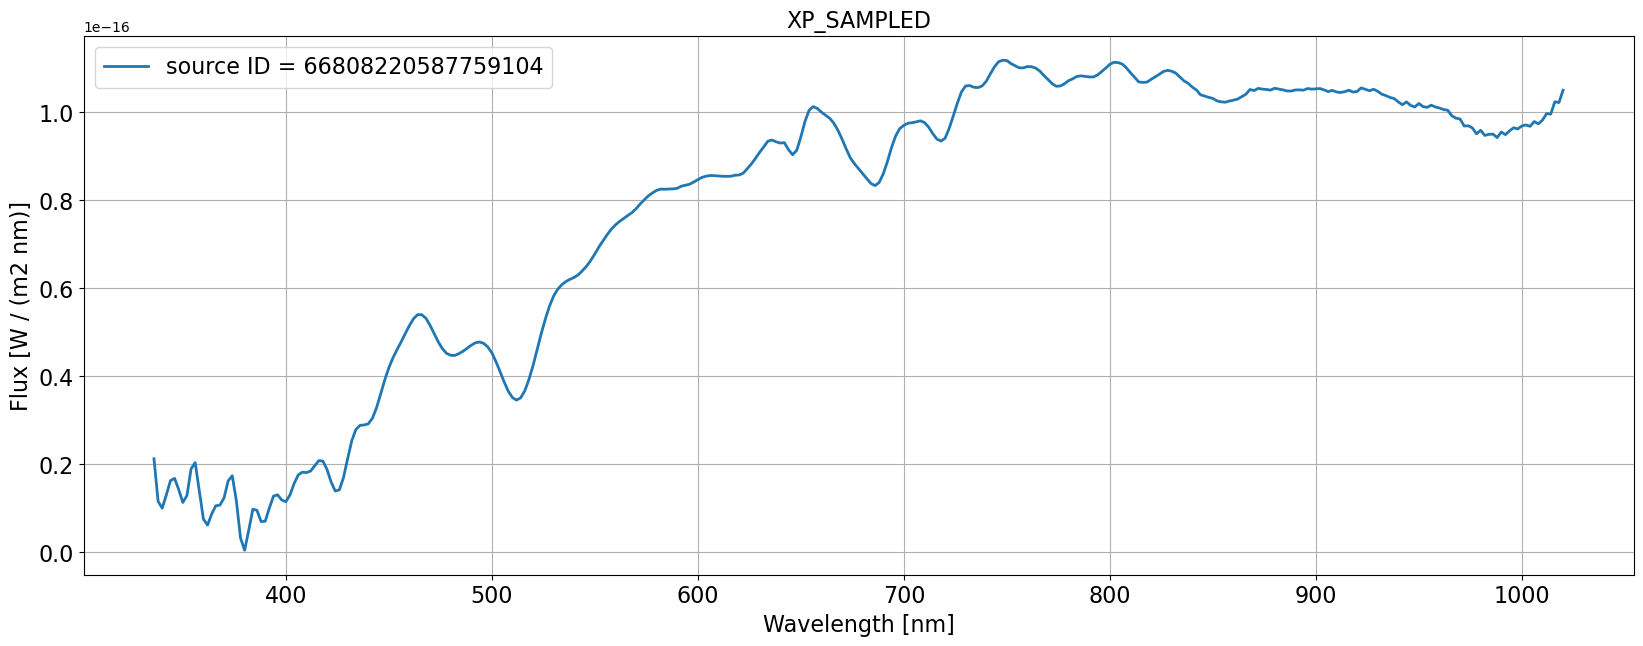

In [9]:
source_ids  = [product.get_field_by_id("source_id").value for product in datalink[dl_key]] # Source IDs are stored in the table metadata.
index       = 100

source_id  = source_ids[index]
xp_samp_tb = datalink['XP_SAMPLED_COMBINED.xml'][index].to_table()

print(f'Listing XP spectra for: Gaia DR3 {source_id}')
display(xp_samp_tb)

plot_sampled_spec(xp_samp_tb, title=dl_key.replace('_COMBINED.xml', ''), legend = f'source ID = {source_id}', show_plot=True, figsize=[20,7])

## XP continuous

The cell below shows how to retrieve XP Continuous spectra for just 3 sources. The GaiaXPy tool contains various functionalities to exploit the information contained in these files.

In [10]:
inp_samp       = pl_samp[pl_samp['has_xp_continuous'] == True][0:3]
retrieval_type = 'XP_CONTINUOUS'
data_structure = 'COMBINED'
dl_key         = 'XP_CONTINUOUS_COMBINED.xml'  # With Python f-strings: dl_key = f'{retrieval_type}_{data_structure}.xml'


datalink     = Gaia.load_data(ids=inp_samp['source_id'], retrieval_type=retrieval_type, data_structure = data_structure)
datalink_out = datalink['XP_CONTINUOUS_COMBINED.xml'][0].to_table()

print(f"* {len(datalink_out)} XP Continuous spectra have been downloaded")

* 3 XP Continuous spectra have been downloaded
